# CCE Moorings - Temporal Scales Analysis  

**Purpose**: Code for computing the mean autocorrelation function for scalar fields from CCE moorings.

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook: 

In [1]:
%matplotlib inline

Import python libraries

In [2]:
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
from netCDF4 import Dataset, num2date
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import cmocean
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.lines as mlines

# Set path to access python functions
ROOT = '/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/'
sys.path.append(ROOT + 'AirSeaCoupling/tools/')

#--- Other Functions ---# 
import cartopy_figs as cart
from autocorr import compute_autocorr_optimize, compute_decor_scale_optimize
from spectra import spectrum1D_frequency, spectral_slope
from lsf import unweighted_lsf, compute_amp_phase, compute_amp_phase_unc, detrend
from structure_functions import compute_structure_function

Set data analysis parameters

In [3]:
# Set processing parameters
option_mooring       = 'CCE1' # Specifies which mooring will analyzed. 
option_obs           = 'CTD'  # Specifies the observational instrumentation to process. Options include: 'CTD', 'CHL', 'ADCP'
option_grid          = 1      # Specifies whether the gridded product or the nearest neighbor depth-correct approach approach is used

# Set time and space parameters
T               = 1*(60)*(60)                         # Spcifies the time interval for model run. Units: seconds
estimator       = 'biased'                            # Specifies the approach for estimating the autocorrelation function  
start_time      = datetime(2016, 1, 1, 0, 0, 0)      # Specifies the start time of the event period  datetime(2016, 1, 1, 0, 0, 0) datetime(2025, 3, 12, 0, 0, 0)
end_time        = datetime(2017, 12, 31, 23, 59, 59)     # Specifies the end time of the event period        datetime(2025, 12, 31, 23, 59, 59)  datetime(2025, 6, 23, 0, 0, 0) 
event_time_bnds = [start_time, end_time]              # Specifies the event period

# Set path to project directory
PATH = "/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling"
PATH_bathy  = ROOT + 'AirSeaCoupling/data/bathymetry/'

# Set plotting parameters 
fontsize = 14

Load CCE processed data

In [4]:
# Set the file name and read in the data file
if option_grid == 1:
    filename_CCE = PATH + "/data/CCE/" + option_mooring + "/" + option_obs + "/" + option_mooring + "_" + option_obs + "_" + str(start_time.year) + str(start_time.month) + str(start_time.day) +  "-" + str(end_time.year) + str(end_time.month) + str(end_time.day) + "_intermediate_gridded_data.nc"
else:
    filename_CCE = PATH + "/data/CCE/" + option_mooring + "/" + option_obs + "/" + option_mooring + "_" + option_obs + "_" + str(start_time.year) + str(start_time.month) + str(start_time.day) +  "-" + str(end_time.year) + str(end_time.month) + str(end_time.day) + "_intermediate_data.nc"
nc_CCE = Dataset(filename_CCE, 'r')

# Extract data variables
depth           = nc_CCE.variables['depth'][:]
time            = num2date(nc_CCE.variables['time'][:], nc_CCE.variables['time'].units)
lon             = nc_CCE.variables['LON'][:]
lat             = nc_CCE.variables['LAT'][:]

sigma0         = nc_CCE.variables['SIG0'][:]
SA             = nc_CCE.variables['ASal'][:]
CT             = nc_CCE.variables['CTemp'][:]

# Convert cftime.DatetimeGregorian to Python datetime objects
time_dt = np.array([datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time])

Preform scale analysis

In [6]:
# Set parameters
ndepth,ntime = np.shape(sigma0)
lag = ntime
w1, w2 = [(2*np.pi)/31557600, (1/2)*(2*np.pi)/31557600]      # Radian Frequency for annual and semi-annual cycles. Units: rad/sec
M = 20                                                       # Specifies number of windows to divide the data into for the Welch method
p = ntime // M                                               # Specifies window length, i.e., number of data points in each segment
nfft = (p // 2 + 1) if (p % 2 == 0) else ((p - 1) // 2)      # Specifies number of positive frequency bins in the resulting power spectrum
units = 'Hz'

# Define frequency range for slope fitting (sub-interial and super-inertial)
fmin_sub = 6*10**(-2) 
fmax_sub = 6*10**(-1) 
fmin_sup = 2*10**(0)
fmax_sup = 1.25*10**(1)

#Convert to seconds since start time
t0 = time[0]
time_elapsed = np.array([(t - t0).total_seconds() for t in time])

#--- Temperature --- #

# Initialize arrays 
autocorr_temp       = np.zeros((ntime,ndepth))
time_scale_temp     = np.zeros((ntime,ndepth))
L_t_temp            = np.zeros((ndepth))
S_temp              = np.zeros((nfft,ndepth))
CI_temp             = np.zeros((nfft,2,ndepth))
S_temp_slope_sub    = np.zeros((ndepth))
S_temp_slope_unc_sub = np.zeros((ndepth))
S_temp_slope_sup    = np.zeros((ndepth))
S_temp_slope_unc_sup = np.zeros((ndepth))
E_scale_temp        = np.zeros((ndepth))

# Set counter
cn_depth = 0 

# Loop through depths 
for idepth in range(0,ndepth):
    
    # Set progress bar
    progress = (idepth) / (len(depth))
    sys.stdout.write(f"\rProgress: {progress:.1%}")
    sys.stdout.flush()
        
    # Initialize the ith time series 
    data_ts = CT[idepth,:]

    # Remove annual and semi-annual cycle 
    hfit, x_data, x_data_sigma, _ = unweighted_lsf(data_ts, time_elapsed, parameters = 2, freqs = np.array([w1,w2]), sigma = None)
    data_ts_rm = data_ts - hfit

    # Detrend data record 
    data_dt = detrend(data_ts_rm, time_elapsed, mean = 0)

    # Compute autocorrelation function
    autocorr_temp[:,cn_depth], _, _, _, time_scale_temp[:,cn_depth], _ = compute_autocorr_optimize(data_dt, time_elapsed, lag, estimator, 0)

    # Compute the decorrelation scale
    L_t_temp[cn_depth] = compute_decor_scale_optimize(autocorr_temp[:,cn_depth],time_scale_temp[:,cn_depth],T,'unbiased',0)

    # Compute frequency power spectrum 
    data_interp = np.interp(time_elapsed, time_elapsed[~data_dt.mask], data_dt[~data_dt.mask])
    S_temp[:,cn_depth], f_temp, CI_temp[:,:,cn_depth], _ = spectrum1D_frequency(data_interp, T, M, units)

    # Compute the energy-containing scales
    f_zero = f_temp[f_temp > 0]
    S_zero = S_temp[f_temp > 0,cn_depth]
    spectral_centroid = np.trapz(f_zero * S_zero, f_zero) / np.trapz(S_zero, f_zero)
    E_scale_temp[cn_depth] = (1 / spectral_centroid) * (1/(60*60*24))    # Units: days

    # Compute the sub-inertial and super inertial spectral slope
    f_cpd = f_temp*(60)*(60)*(24)
    S_temp_slope_sub[cn_depth], S_temp_slope_unc_sub[cn_depth], S_temp_fit_sub, f_range_sub = spectral_slope(f_cpd, S_temp[:,cn_depth], fmin_sub, fmax_sub)
    S_temp_slope_sup[cn_depth], S_temp_slope_unc_sup[cn_depth], S_temp_fit_sup, f_range_sup = spectral_slope(f_cpd, S_temp[:,cn_depth], fmin_sup, fmax_sup)

    # Plot sample 
    # plt.figure(figsize=(8, 5))
    # plt.loglog(f_cpd, S_temp[:,cn_depth], label='PSD')
    # plt.loglog(f_range_sub, S_temp_fit_sub, '--r', label=f'Fit: slope = {S_temp_slope_sub[cn_depth]:.2f} ± {S_temp_slope_unc_sub[cn_depth]:.2f}')
    # plt.loglog(f_range_sup, S_temp_fit_sup, '--b', label=f'Fit: slope = {S_temp_slope_sup[cn_depth]:.2f} ± {S_temp_slope_unc_sup[cn_depth]:.2f}')
    # plt.xlabel('Frequency [Hz]')
    # plt.ylabel('PSD')
    # plt.title('Spectral Slope Test')
    # plt.legend()
    # plt.grid(True, which='both', ls='--')
    # plt.tight_layout()
    # plt.show()

    # Compute structure function
    #S_i, lag_i = compute_structure_function(data_m, lag, orders=[1, 2, 3, 4])

    # Set longitude counter
    cn_depth = cn_depth + 1

# Convert time scale to units of days
Lt_temp = L_t_temp*(1/60)*(1/60)*(1/24)

#--- Salinity ---# 

# Initialize arrays 
autocorr_sal       = np.zeros((ntime,ndepth))
time_scale_sal     = np.zeros((ntime,ndepth))
L_t_sal            = np.zeros((ndepth))
S_sal              = np.zeros((nfft,ndepth))
CI_sal             = np.zeros((nfft,2,ndepth))
S_sal_slope_sub    = np.zeros((ndepth))
S_sal_slope_unc_sub = np.zeros((ndepth))
S_sal_slope_sup    = np.zeros((ndepth))
S_sal_slope_unc_sup = np.zeros((ndepth))
E_scale_sal        = np.zeros((ndepth))

# Set counter
cn_depth = 0 

# Loop through depths 
for idepth in range(0,ndepth):
    
    # Set progress bar
    progress = (idepth) / (len(depth))
    sys.stdout.write(f"\rProgress: {progress:.1%}")
    sys.stdout.flush()
        
    # Initialize the ith time series 
    data_ts = SA[idepth,:]

    # Remove annual and semi-annual cycle 
    hfit, x_data, x_data_sigma, _ = unweighted_lsf(data_ts, time_elapsed, parameters = 2, freqs = np.array([w1,w2]), sigma = None)
    data_ts_rm = data_ts - hfit

    # Detrend data record 
    data_dt = detrend(data_ts_rm, time_elapsed, mean = 0)

    # Compute autocorrelation function
    autocorr_sal[:,cn_depth], _, _, _, time_scale_sal[:,cn_depth], _ = compute_autocorr_optimize(data_dt, time_elapsed, lag, estimator, 0)

    # Compute the decorrelation scale
    L_t_sal[cn_depth] = compute_decor_scale_optimize(autocorr_sal[:,cn_depth],time_scale_sal[:,cn_depth],T,'unbiased',0)

    # Compute frequency power spectrum 
    data_interp = np.interp(time_elapsed, time_elapsed[~data_dt.mask], data_dt[~data_dt.mask])
    S_sal[:,cn_depth], f_sal, CI_sal[:,:,cn_depth], _ = spectrum1D_frequency(data_interp, T, M, units)

    # Compute the energy-containing scales
    f_zero = f_sal[f_sal > 0]
    S_zero = S_sal[f_sal > 0,cn_depth]
    spectral_centroid = np.trapz(f_zero * S_zero, f_zero) / np.trapz(S_zero, f_zero)
    E_scale_sal[cn_depth] = (1 / spectral_centroid) * (1/(60*60*24))    # Units: days

    # Compute the sub-inertial and super inertial spectral slope
    f_cpd = f_sal*(60)*(60)*(24)
    S_sal_slope_sub[cn_depth], S_sal_slope_unc_sub[cn_depth], S_sal_fit_sub, f_range_sub = spectral_slope(f_cpd, S_sal[:,cn_depth], fmin_sub, fmax_sub)
    S_sal_slope_sup[cn_depth], S_sal_slope_unc_sup[cn_depth], S_sal_fit_sup, f_range_sup = spectral_slope(f_cpd, S_sal[:,cn_depth], fmin_sup, fmax_sup)

    # Compute structure function
    #S_i, lag_i = compute_structure_function(data_m, lag, orders=[1, 2, 3, 4])

    # Set longitude counter
    cn_depth = cn_depth + 1

# Convert time scale to units of days
Lt_sal = L_t_sal*(1/60)*(1/60)*(1/24)

#--- Density ---# 

# Initialize arrays 
autocorr_rho       = np.zeros((ntime,ndepth))
time_scale_rho     = np.zeros((ntime,ndepth))
L_t_rho            = np.zeros((ndepth))
S_rho              = np.zeros((nfft,ndepth))
CI_rho             = np.zeros((nfft,2,ndepth))
S_rho_slope_sub    = np.zeros((ndepth))
S_rho_slope_unc_sub = np.zeros((ndepth))
S_rho_slope_sup    = np.zeros((ndepth))
S_rho_slope_unc_sup = np.zeros((ndepth))
E_scale_rho        = np.zeros((ndepth))

# Set counter
cn_depth = 0 

# Loop through depths 
for idepth in range(0,ndepth):
    
    # Set progress bar
    progress = (idepth) / (len(depth))
    sys.stdout.write(f"\rProgress: {progress:.1%}")
    sys.stdout.flush()
        
    # Initialize the ith time series 
    data_ts = sigma0[idepth,:]

    # Remove annual and semi-annual cycle 
    hfit, x_data, x_data_sigma, _ = unweighted_lsf(data_ts, time_elapsed, parameters = 2, freqs = np.array([w1,w2]), sigma = None)
    data_ts_rm = data_ts - hfit

    # Detrend data record 
    data_dt = detrend(data_ts_rm, time_elapsed, mean = 0)

    # Compute autocorrelation function
    autocorr_rho[:,cn_depth], _, _, _, time_scale_rho[:,cn_depth], _ = compute_autocorr_optimize(data_dt, time_elapsed, lag, estimator, 0)

    # Compute the decorrelation scale
    L_t_rho[cn_depth] = compute_decor_scale_optimize(autocorr_rho[:,cn_depth],time_scale_rho[:,cn_depth],T,'unbiased',0)

    # Compute frequency power spectrum 
    data_interp = np.interp(time_elapsed, time_elapsed[~data_dt.mask], data_dt[~data_dt.mask])
    S_rho[:,cn_depth], f_rho, CI_rho[:,:,cn_depth], _ = spectrum1D_frequency(data_interp, T, M, units)

    # Compute the energy-containing scales
    f_zero = f_rho[f_rho > 0]
    S_zero = S_rho[f_rho > 0,cn_depth]
    spectral_centroid = np.trapz(f_zero * S_zero, f_zero) / np.trapz(S_zero, f_zero)
    E_scale_rho[cn_depth] = (1 / spectral_centroid) * (1/(60*60*24))    # Units: days

    # Compute the sub-inertial and super inertial spectral slope
    f_cpd = f_rho*(60)*(60)*(24)
    S_rho_slope_sub[cn_depth], S_rho_slope_unc_sub[cn_depth], S_rho_fit_sub, f_range_sub = spectral_slope(f_cpd, S_rho[:,cn_depth], fmin_sub, fmax_sub)
    S_rho_slope_sup[cn_depth], S_rho_slope_unc_sup[cn_depth], S_rho_fit_sup, f_range_sup = spectral_slope(f_cpd, S_rho[:,cn_depth], fmin_sup, fmax_sup)

    # Compute structure function
    #S_i, lag_i = compute_structure_function(data_m, lag, orders=[1, 2, 3, 4])

    # Set longitude counter
    cn_depth = cn_depth + 1

# Convert time scale to units of days
Lt_rho = L_t_rho*(1/60)*(1/60)*(1/24)


Progress: 92.3%

Plot a comparison of the decorrelation scales from each of the variables

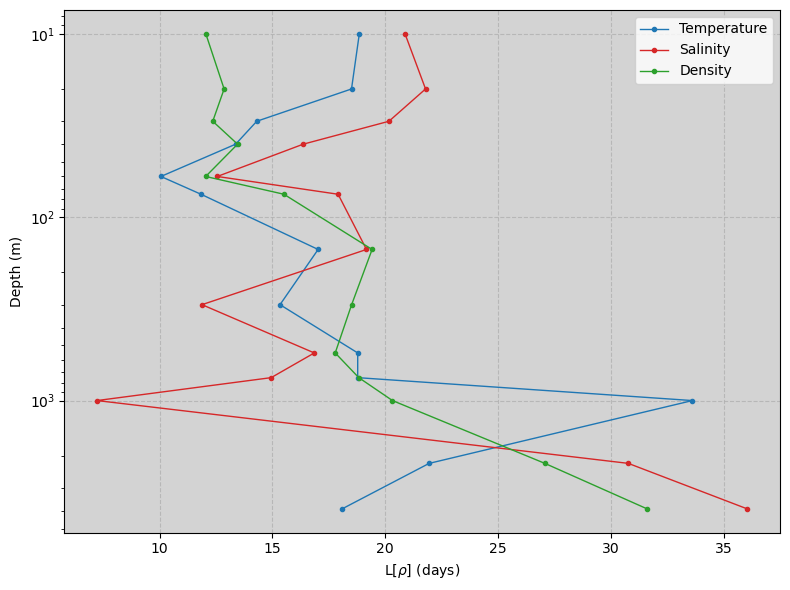

In [6]:
# Create the figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Plot the decorrelation length scale
ax.semilogy(Lt_temp, depth, '.-', color='tab:blue', linewidth=1,label='Temperature')
ax.semilogy(Lt_sal, depth, '.-', color='tab:red', linewidth=1, label='Salinity')
ax.semilogy(Lt_rho, depth, '.-', color='tab:green', linewidth=1, label='Density')

# Set figure attributes
ax.set_xlabel(r'L[$\rho$] (days)')
ax.set_ylabel('Depth (m)')
ax.grid(True,linestyle='--',alpha=0.8)
ax.legend()

# Reverse the direction of the x-axis 
ax.invert_yaxis() 

# Set the background color of the axes
ax.set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()

Plot the relationship between the spectral slope and the decorrelation scale

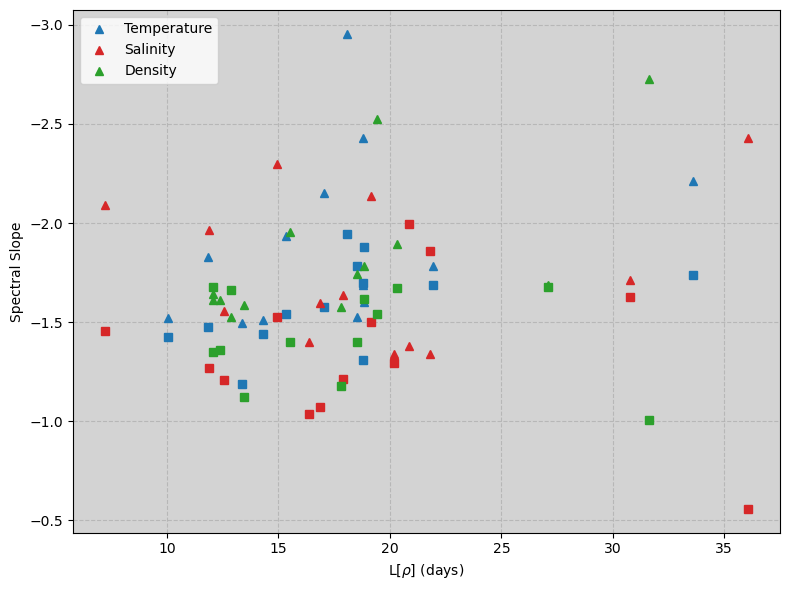

In [7]:
# Create the figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Plot the decorrelation length scale
ax.plot(Lt_temp, S_temp_slope_sub, '^', color='tab:blue', linewidth=1,label='Temperature')
ax.plot(Lt_temp, S_temp_slope_sup, 's', color='tab:blue', linewidth=1)
ax.plot(Lt_sal, S_sal_slope_sub, '^', color='tab:red', linewidth=1,label='Salinity')
ax.plot(Lt_sal, S_sal_slope_sup, 's', color='tab:red', linewidth=1)
ax.plot(Lt_rho, S_rho_slope_sub, '^', color='tab:green', linewidth=1,label='Density')
ax.plot(Lt_rho, S_rho_slope_sup, 's', color='tab:green', linewidth=1)

# Set figure attributes
ax.set_xlabel(r'L[$\rho$] (days)')
ax.set_ylabel('Spectral Slope')
ax.grid(True,linestyle='--',alpha=0.8)
ax.legend()

# Reverse the direction of the x-axis 
ax.invert_yaxis() 

# Set the background color of the axes
ax.set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()

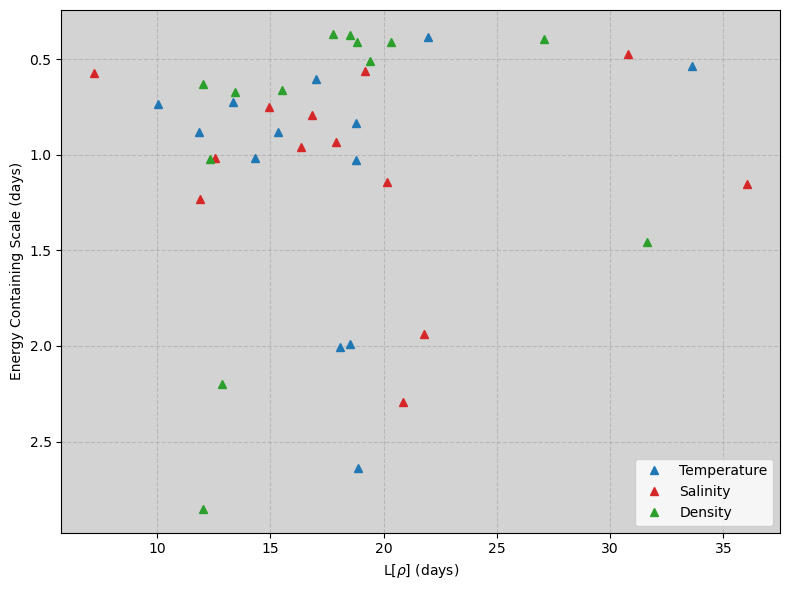

In [8]:
# Create the figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Plot the decorrelation length scale
ax.plot(Lt_temp, E_scale_temp, '^', color='tab:blue', linewidth=1,label='Temperature')
ax.plot(Lt_sal, E_scale_sal, '^', color='tab:red', linewidth=1,label='Salinity')
ax.plot(Lt_rho, E_scale_rho, '^', color='tab:green', linewidth=1,label='Density')

# Set figure attributes
ax.set_xlabel(r'L[$\rho$] (days)')
ax.set_ylabel('Energy Containing Scale (days)')
ax.grid(True,linestyle='--',alpha=0.8)
ax.legend()

# Reverse the direction of the x-axis 
ax.invert_yaxis() 

# Set the background color of the axes
ax.set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()

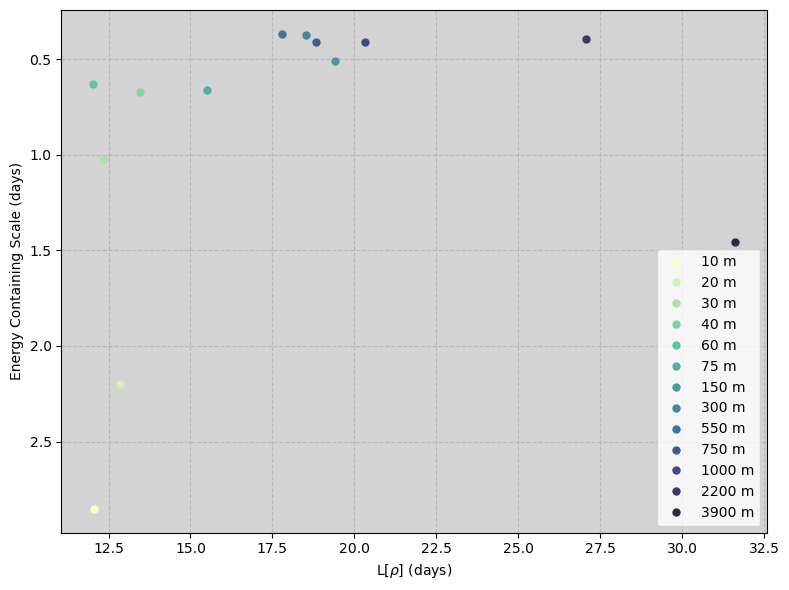

In [60]:
# Create the figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Set colormap fro depths
cmap = cmocean.cm.deep
colors = [cmap(i / len(depth)) for i in range(len(depth))]

# Plot each depth
for i, idepth in enumerate(depth):
    ax.plot(Lt_rho[i], E_scale_rho[i], '.', color=colors[i], markersize=10, label=f"{idepth} m")

# Set legend
ax.legend(title="Depth", loc='upper right', fontsize=9, title_fontsize=9)

# Set figure attributes
ax.set_xlabel(r'L[$\rho$] (days)')
ax.set_ylabel('Energy Containing Scale (days)')
ax.grid(True,linestyle='--',alpha=0.8)
ax.legend()

# Reverse the direction of the x-axis 
ax.invert_yaxis() 

# Set the background color of the axes
ax.set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()

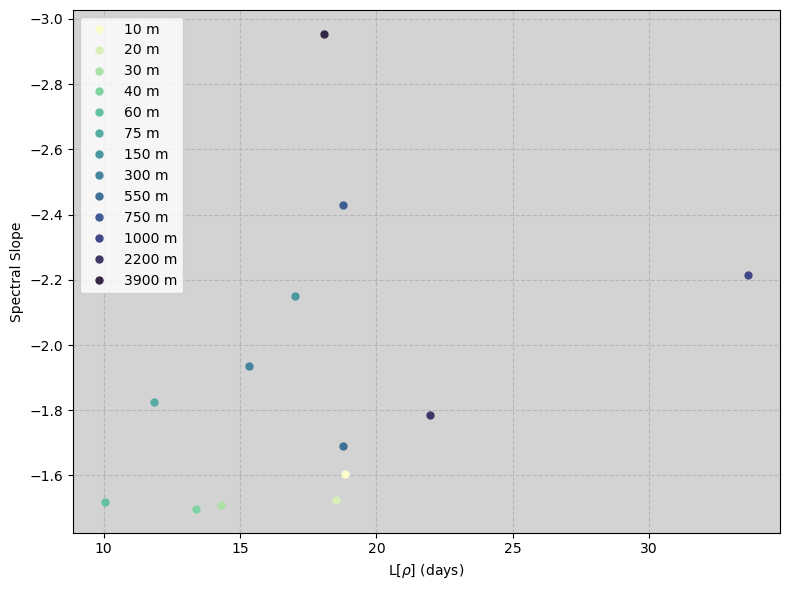

In [59]:
# Create the figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Set colormap fro depths
cmap = cmocean.cm.deep
colors = [cmap(i / len(depth)) for i in range(len(depth))]

# Plot each depth
for i, idepth in enumerate(depth):
    ax.plot(Lt_temp[i], S_temp_slope_sub[i], '.', color=colors[i], markersize=10, label=f"{idepth} m")

# Set legend
ax.legend(title="Depth", loc='upper right', fontsize=9, title_fontsize=9)

# Set figure attributes
ax.set_xlabel(r'L[$\rho$] (days)')
ax.set_ylabel('Spectral Slope')
ax.grid(True,linestyle='--',alpha=0.8)
ax.legend()

# Reverse the direction of the x-axis 
ax.invert_yaxis() 

# Set the background color of the axes
ax.set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()

Set which variable you would like to plot

In [ ]:
# Specify which variable will analyzed. Options include: temp, sal, density
option_var     = 'temp'

# Set the data to plot
if option_var == 'temp':
    autocorr   = autocorr_temp
    time_scale = time_scale_temp  # Units: seconds
    Lt         = Lt_temp          # Units: days
    L_t        = L_t_temp         # Units: seconds
    S          = S_temp           # Units: (deg C)^2/Hz
    CI         = CI_temp
    f          = f_temp           # Units: Hz 
elif option_var == 'sal':
    autocorr   = autocorr_sal
    time_scale = time_scale_sal
    Lt         = Lt_sal  
    L_t        = L_t_sal
    S          = S_sal            # Units: (g/Kg)^2/Hz
    CI         = CI_sal
    f          = f_sal
elif option_var == 'density':
    autocorr   = autocorr_rho
    time_scale = time_scale_rho
    Lt         = Lt_rho
    L_t        = L_t_rho
    S          = S_rho            # Units: (kg/m^3)^2/Hz
    CI         = CI_rho
    f          = f_rho

# Convert time scale to months
time_scale_days = time_scale*(1/60)*(1/60)*(1/24)

# Convert the decorrelation time scale to units of days 
Lt_days = L_t*(1/60)*(1/60)*(1/24)

# Multiply the decorrelation scale by pi so that it is comparable to the period of a signal
T = Lt_days

# Compute its associated frequency in units of cpd and multiply by 
f_decor = (1/T)*(2*np.pi)

# Convert frequency from Hz to cpd
f_cpd = f*(60)*(60)*(24)

# Compute the interial period in units of cpd
omega = (7.2921*10**(-5))/(2*np.pi)                   # Units: Hz 
f_inertial = 2*omega*np.sin(np.deg2rad(lat))*(86400)  # Units: cpd


Plot the autocorrelation functions and decorrelation scales 

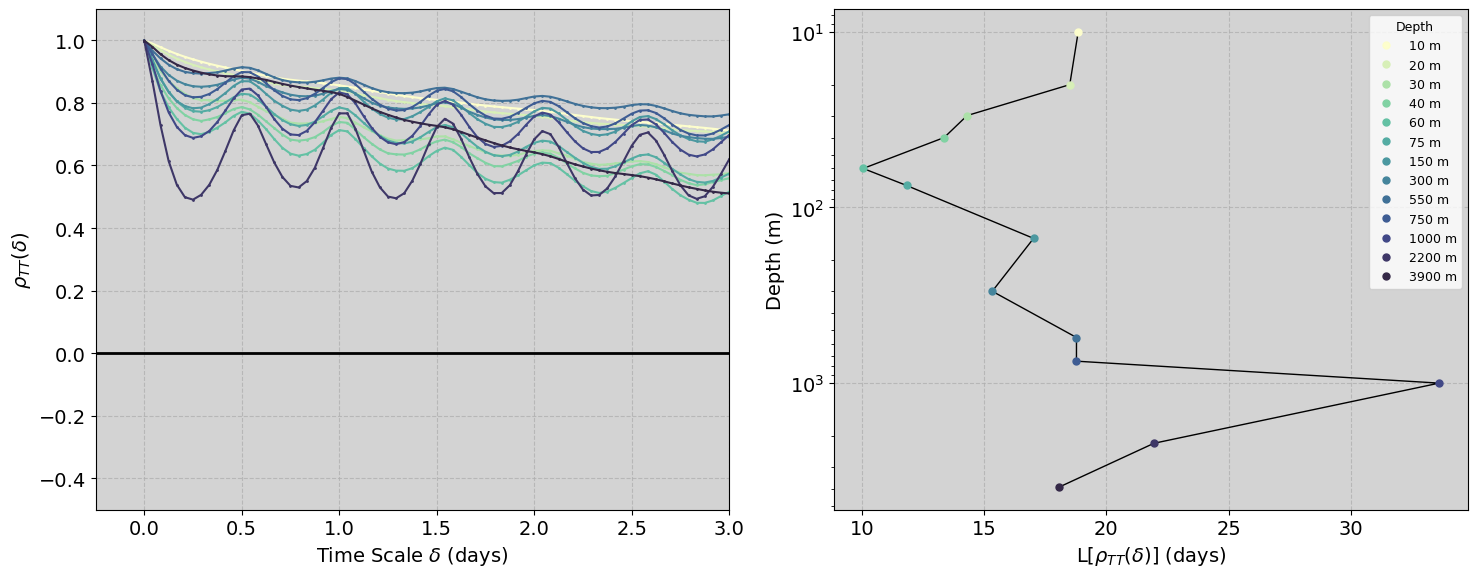

In [69]:
# Set the fontsize
plt.rcParams.update({'font.size': fontsize})

# Set plotting parameters
if option_var == 'temp':
    ylabel = r'$\rho_{TT} (\delta)$'
elif option_var == 'sal':
    ylabel = r'$\rho_{SS} (\delta)$'
elif option_var == 'density': 
    ylabel = r'$\rho_{\sigma\sigma} (\delta)$'

# Set colormap fro depths
cmap = cmocean.cm.deep
colors = [cmap(i / len(depth)) for i in range(len(depth))]

# Create figure 
fig, ax = plt.subplots(1,2,figsize=(15, 6))

#--- Subplot #1 ---# 

# Plot the zero crossing line
ax[0].axhline(0, color='k', linestyle='-', linewidth=2)

# Plot each depth
for i, idepth in enumerate(depth):
    ax[0].plot(time_scale_days[:,i], autocorr[:,i], '.-', label=f"{idepth} m", color=colors[i], linewidth=1.5, markersize=2)

# Set figure attributes
ax[0].set_xlabel(r"Time Scale $\delta$ (days)")
ax[0].set_ylabel(ylabel)
ax[0].set_xlim(-0.25,3)
ax[0].set_ylim(-0.5,1.1)
ax[0].grid(True,linestyle='--',alpha=0.8)

# Set the background color of the axes
ax[0].set_facecolor('lightgray')

#--- Subplot #2 ---# 

# Plot the decorrelation length scale
ax[1].semilogy(Lt, depth, '-', color='k', linewidth=1)

# Plot each depth
for i, idepth in enumerate(depth):
    ax[1].plot(Lt[i], idepth, '.', color=colors[i], markersize=10, label=f"{idepth} m",)

# Set legend
ax[1].legend(title="Depth", loc='upper right', fontsize=9, title_fontsize=9)

# Set figure attributes
ax[1].set_xlabel('L[' + ylabel + '] (days)')
ax[1].set_ylabel('Depth (m)')
ax[1].grid(True,linestyle='--',alpha=0.8)

# Reverse the direction of the x-axis 
ax[1].invert_yaxis() 

# Set the background color of the axes
ax[1].set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()

# Save figure 
fig.savefig(fname = PATH + '/figs/CCE/' + option_mooring + '/autocorr_decor_scale_depth_dependence' + option_var, bbox_inches = 'tight', dpi=300)


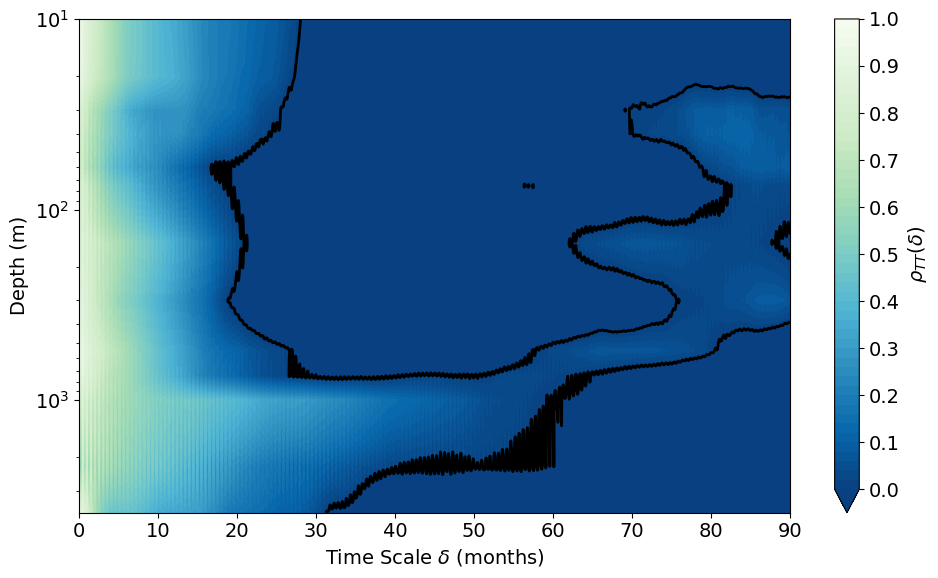

In [63]:
# Set the fontsize
plt.rcParams.update({'font.size': fontsize})

# Set colormap and levels
cmap = plt.cm.GnBu_r
levels=np.arange(0,1+0.02,0.02)

# Create the figure
fig = plt.figure(figsize=(10, 6))

#--- Subplot #1 ---# 
ax1 = fig.add_subplot(111)

# Create meshgrid and zeros surface 
T, D = np.meshgrid(time_scale_days[:,1], depth)  

# Plot autocorrelation surface
contour = ax1.contourf(T,D,autocorr.T,levels=levels,cmap=cmap,extend='min')

# Plot and label the zero contour 
zero_contour = plt.contour(T,D,autocorr.T, levels=[0], colors='black', linewidths=2)

# Set figure attributes
ax1.set_xlabel(r'Time Scale $\delta$ (months)')
ax1.set_ylabel('Depth (m)')
ax1.set_yscale('log')
ax1.set_xlim(0,90)

# Set color bar
cbar = fig.colorbar(contour,extend='min')
cbar.set_ticks(np.arange(0,1+0.1,0.1)) 
cbar.set_label(ylabel)
contour.set_clim(0,1)

# Reverse the direction of the x-axis 
ax1.invert_yaxis() 

# Display figure
plt.tight_layout()
plt.show()


Plot the power spectra at each depth

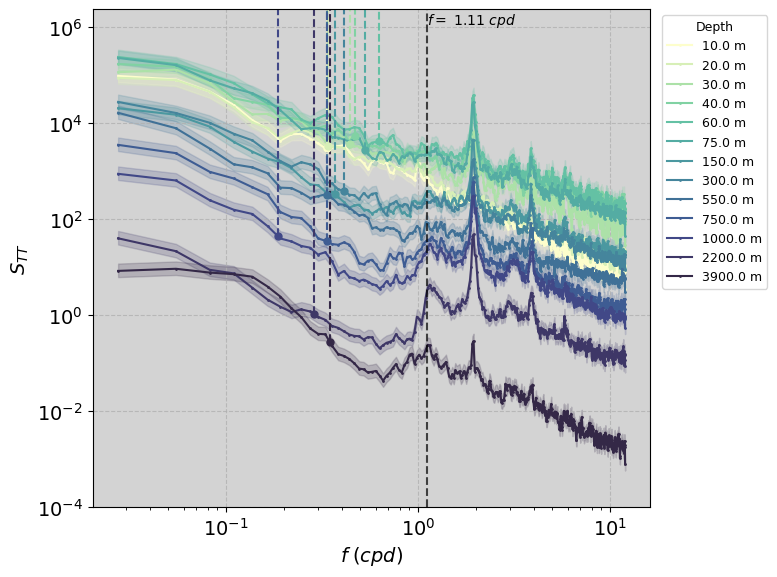

In [68]:
# Set the fontsize
plt.rcParams.update({'font.size': fontsize})

# Set plotting parameters
if option_var == 'temp':
    ylabel = r'$S_{TT}$'
elif option_var == 'sal':
    ylabel = r'$S_{SS}$'
elif option_var == 'density': 
    ylabel = r'$S_{\sigma\sigma}$'

# Set colormap fro depths
cmap = cmocean.cm.deep
colors = [cmap(i / len(depth)) for i in range(len(depth))]

# Create figure 
fig, ax = plt.subplots(1,1,figsize=(8, 6))

# Determine upper y-limit from your spectra (e.g., 1.2 × global max to leave room)
S_max = np.nanmax(S)  # or limit this to a depth range if needed
ymin = 1e-4 # 1e-1
ymax = S_max * 10
ax.set_ylim(bottom=ymin, top=ymax)  # Adjust lower limit if needed

# Plot each depth the spectrum, confidence intervals and the decorrelation scale
for i, idepth in enumerate(depth):

    # Plot the spectrum and CI
    ax.loglog(f_cpd[1:], S[1:,i], '.-', label=f"{idepth:.1f} m", color=colors[i], linewidth=1.5, markersize=2)
    ax.fill_between(f_cpd[1:], CI[1:,0,i], CI[1:,1,i], color=colors[i], alpha=0.2)

    # Convert f_decor to a scalar
    f_i = f_decor[i]

    # Check that decorrelation frequency is within range
    if f_cpd[0] < f_i < f_cpd[-1]:

        # Interpolate power spectrum at f_i
        S_decor = np.interp(f_i, f_cpd, S[:, i])

        # Plot vertical line *only down to the spectrum*
        ax.plot([f_i, f_i], [S_decor, ymax], linestyle='--', color=colors[i], linewidth=1.5)

        # Plot a marker at the intersection point
        ax.plot(f_i, S_decor, marker='o', color=colors[i], markersize=5, zorder=5)

# Plot the inertial frequency lines and text
ax.axvline(f_inertial, color='k', linestyle='--', alpha=0.7)
ax.text(f_inertial, plt.ylim()[1]*0.6, r'$f = $ ' + str(np.round(f_inertial,2)) + r' $cpd$', rotation=0, verticalalignment='center', horizontalalignment='left', color='k', alpha=1, fontsize=10)

# Set legend
ax.legend(title="Depth", bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9, title_fontsize=9)

# Set figure attributes
ax.set_xlabel(r"$f \;(cpd)$")
ax.set_ylabel(ylabel)
ax.grid(True,linestyle='--',alpha=0.8)

# Set the background color of the axes
ax.set_facecolor('lightgray')

# Display figure
plt.tight_layout()
plt.show()

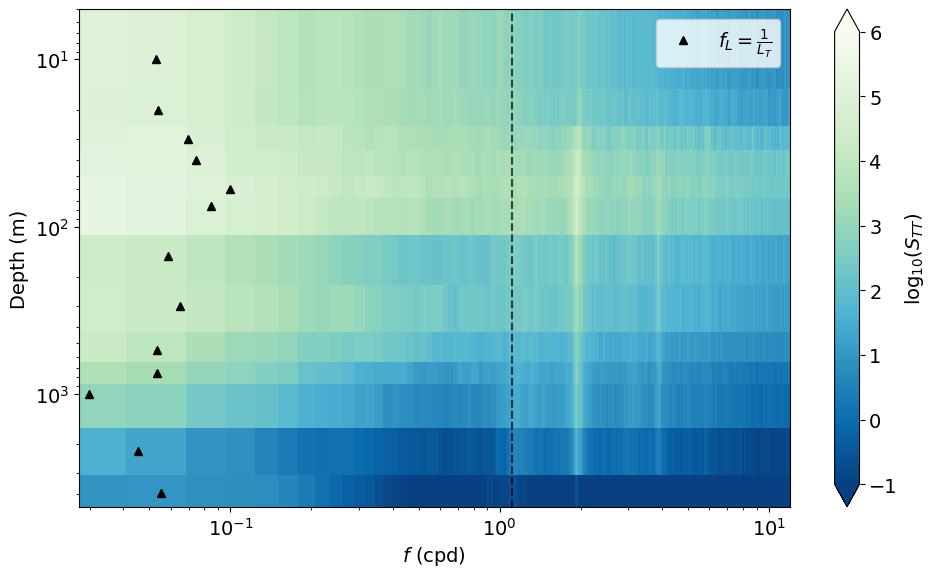

In [65]:
# Set the fontsize
plt.rcParams.update({'font.size': fontsize})

# Set colormap and levels
cmap = plt.cm.GnBu_r
levels=np.arange(-2,6+0.05,0.05)

# Create the figure
fig = plt.figure(figsize=(10, 6))

#--- Subplot #1 ---# 
ax1 = fig.add_subplot(111)

# Create meshgrid and zeros surface 
F, D = np.meshgrid(f_cpd, depth)  

# Plot autocorrelation surface
contour = ax1.pcolormesh(F,D,np.log10(S.T),cmap=cmap,shading='auto')

# Overlay decorrelation frequency markers
ax1.plot(f_decor, depth, 'k^', markersize=6, label=r'$f_L = \frac{1}{L_T}$')

# Plot the inertial frequency lines and text
ax1.axvline(f_inertial, color='k', linestyle='--', alpha=0.7)
#ax1.text(f_inertial, plt.ylim()[0]*0.9, r'$f = $ ' + str(np.round(f_inertial,2)) + r' $cpd$', rotation=0, verticalalignment='center', horizontalalignment='left', color='k', alpha=1, fontsize=10)

# Set figure attributes
ax1.set_xlabel(r'$f$ (cpd)')
ax1.set_ylabel('Depth (m)')
ax1.set_xticks(np.arange(0,13,1))
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(f_cpd[1],f_cpd[-1])
ax1.legend(loc='upper right')

# Set color bar
cbar = fig.colorbar(contour,extend='both')
cbar.set_ticks(np.arange(-1,6+1,1)) 
cbar.set_label(r'log$_{10}$(' + ylabel + ')')
contour.set_clim(-1,6)

# Reverse the direction of the x-axis 
ax1.invert_yaxis() 

# Display figure
plt.tight_layout()
plt.show()


Save data into an intermediate product npz file

In [66]:
#--- Autocorrelation and decorrelation scales ---# 

# Check if file exists, then delete it
if option_grid == 1:
    file_path = PATH + "/data/CCE/" + option_mooring + "/" + option_obs + "/" + option_mooring + "_" + option_obs + "_" + str(start_time.year) + str(start_time.month) + str(start_time.day) +  "-" + str(end_time.year) + str(end_time.month) + str(end_time.day) + "_scale_data_gridded.npz"
else:
    file_path = PATH + "/data/CCE/" + option_mooring + "/" + option_obs + "/" + option_mooring + "_" + option_obs + "_" + str(start_time.year) + str(start_time.month) + str(start_time.day) +  "-" + str(end_time.year) + str(end_time.month) + str(end_time.day) + "_scale_data.npz"
if os.path.exists(file_path):
    os.remove(file_path)

# Set metadata
metadata = {
    'description': 'Temporal decorrelation scale from the ' + option_mooring + ' mooring for the ' + option_obs + '. Here, the annual and semi-annual cycles are removed before computing the decorrelation scale.',
    'source': option_mooring + 'mooring',
    'coordinates units': 'hr'
}

# Save data arrays and metadata to a .npz file
np.savez(file_path, 
        autocorr_temp      = autocorr_temp,
        autocorr_sal       = autocorr_sal,
        autocorr_rho       = autocorr_rho,
        time_scale_temp    = time_scale_temp,  # Units: seconds
        time_scale_sal     = time_scale_sal,   # Units: seconds
        time_scale_rho     = time_scale_rho,   # Units: seconds
        Lt_temp            = Lt_temp,          # Units: days
        Lt_sal             = Lt_sal,           # Units: days
        Lt_rho             = Lt_rho,           # Units: days
        S_temp             = S_temp,           # Units: (deg C)^2/Hz
        S_sal              = S_sal,            # Units: (g/kg)^2/Hz
        S_rho              = S_rho,            # Units: (kg/m^3)^2/Hz
        CI_temp            = CI_temp, 
        CI_sal             = CI_sal, 
        CI_rho             = CI_rho, 
        f_temp             = f_temp,           # Units: Hz
        f_sal              = f_sal,            # Units: Hz
        f_rho              = f_rho,            # Units: Hz
        lon                = lon,
        lat                = lat,
        depth              = depth,
        metadata           = metadata
        )